# Overview all materials:

This notebook provides an overview of all materials and the performance a model for each of them.
Note, that all of these models are trained in a cross-validation setting (i.e., some of the training data is withheld intentionally to investigate the extrapolation performance of the models).

(In the following, all paths will be given relative to the repository root)

In [1]:
# optional setup
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # choose cuda-device
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"  # disable preallocation of memory

import jax
import jax.numpy as jnp
jax.config.update("jax_platform_name", "cpu")  # optionally run on cpu

In [2]:
from rhmag.data_management import AVAILABLE_MATERIALS, MaterialSet, DataSet

from rhmag.utils.data_plotting import plot_sequence_prediction, plot_hysteresis_prediction
from rhmag.utils.model_evaluation import reconstruct_model_from_file, plot_model_frequency_sweep, evaluate_cross_validation
from rhmag.utils.final_data_evaluation import FINAL_SCENARIOS_PER_MATERIAL

INFO:2026-01-27 18:06:20,161:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2026-01-27 18:06:20 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Present materials:

The raw material data is to be stored at `data/raw` and (when all data is present) should look like this:

```text
└── data/raw
    ├── 3C90/
    ├── 3C94/
    ├── 3E6/
    ├── 3F4/
    ├── 77/
    ├── 78/
    ├── Material A/
    ├── Material B/
    ├── Material C/
    ├── Material D/
    ├── Material E/
    ├── N27/
    ├── N30/
    ├── N49/
    ├── N87/
    └── sort_raw_data.py
```

Then run `python data/raw/sort_raw_data.py` from the command line to finish preparing the raw data. The folder should then look like this:

```text
└── data/raw
    ├── 3C90/
    ├── 3C94/
    ├── 3E6/
    ├── 3F4/
    ├── 77/
    ├── 78/
    ├── A/
    ├── B/
    ├── C/
    ├── D/
    ├── E/
    ├── N27/
    ├── N30/
    ├── N49/
    ├── N87/
    └── sort_raw_data.py
```


Upon first load of a each file, it will be stored in the cache at `data/cache` in the form of `.parquet` files.
The first load will be substantially slower as the data is loaded directly from `.csv`.
Following loads of the material data will go much faster.

In [3]:
print("Number of materials:", len(AVAILABLE_MATERIALS))
print(AVAILABLE_MATERIALS)
print()

Number of materials: 15
['3C90', '3C94', '3E6', '3F4', '77', '78', 'N27', 'N30', 'N49', 'N87', 'A', 'B', 'C', 'D', 'E']



The whole data set is quite a large amount of data: ~17 GB.

If it does not fit into your RAM or VRAM, you may use a subset of the materials at a time, 
e.g., `data_set = DataSet.from_material_names(AVAILABLE_MATERIALS[:5])` loads the first 5 materials in the list.

In [4]:
data_set = DataSet.from_material_names(AVAILABLE_MATERIALS)

Loading data for N49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.84it/s]


No data found for frequency index 6, skipping frequency.
No data found for frequency index 7, skipping frequency.


Loading data for B:  10%|███████████████████████▌                                                                                                                                                                                                                                | 2/21 [00:01<00:15,  1.26it/s]

Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_T.parquet is empty.


Loading data for B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.96it/s]


Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_T.parquet is empty.
Given DataFrames for B, H, and T at frequency 80000.0 are empty. Skipping this frequency for the given material.
Given DataFrames for B, H, and T at frequency 500000.0 are empty. Skipping this frequency for the given material.


Loading data for E: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  5.13it/s]


Take a stop to inspect the `data_set` object, it is quite expressive thanks to being an `equinox.module` (a lot of the implementation builds on this package, check it out here (https://docs.kidger.site/equinox/))

- A `DataSet` consists of a collection of `MaterialSet`s (One for each material)
- A `MaterialSet` consists of a collection of `FrequencySet`s (One for each frequency)
- A `FrequencySet` holds the actual data in the form of `jax.Array`s

Checkout the methods for each of the classes. There are handy ways to filter each object.

In [5]:
display(data_set)

DataSet(
  material_sets=[
    MaterialSet(
      material_name='3C90',
      frequency_sets=[
        FrequencySet(
          material_name='3C90',
          frequency=50000.0,
          H=f32[647,32016],
          B=f32[647,32016],
          T=i32[647],
          H_RMS=f32[647]
        ),
        FrequencySet(
          material_name='3C90',
          frequency=80000.0,
          H=f32[1459,20016],
          B=f32[1459,20016],
          T=i32[1459],
          H_RMS=f32[1459]
        ),
        FrequencySet(
          material_name='3C90',
          frequency=125000.0,
          H=f32[2252,12816],
          B=f32[2252,12816],
          T=i32[2252],
          H_RMS=f32[2252]
        ),
        FrequencySet(
          material_name='3C90',
          frequency=200000.0,
          H=f32[3252,8015],
          B=f32[3252,8015],
          T=i32[3252],
          H_RMS=f32[3252]
        ),
        FrequencySet(
          material_name='3C90',
          frequency=320000.0,
          H=f32[3269,

In [6]:
data_set.at_material("3C90")  # only data for 3C90

MaterialSet(
  material_name='3C90',
  frequency_sets=[
    FrequencySet(
      material_name='3C90',
      frequency=50000.0,
      H=f32[647,32016],
      B=f32[647,32016],
      T=i32[647],
      H_RMS=f32[647]
    ),
    FrequencySet(
      material_name='3C90',
      frequency=80000.0,
      H=f32[1459,20016],
      B=f32[1459,20016],
      T=i32[1459],
      H_RMS=f32[1459]
    ),
    FrequencySet(
      material_name='3C90',
      frequency=125000.0,
      H=f32[2252,12816],
      B=f32[2252,12816],
      T=i32[2252],
      H_RMS=f32[2252]
    ),
    FrequencySet(
      material_name='3C90',
      frequency=200000.0,
      H=f32[3252,8015],
      B=f32[3252,8015],
      T=i32[3252],
      H_RMS=f32[3252]
    ),
    FrequencySet(
      material_name='3C90',
      frequency=320000.0,
      H=f32[3269,5008],
      B=f32[3269,5008],
      T=i32[3269],
      H_RMS=f32[3269]
    ),
    FrequencySet(
      material_name='3C90',
      frequency=500000.0,
      H=f32[3300,3216],
      B=

In [7]:
data_set.filter_frequencies([50_000])  # only Frequency sets with f=50 kHz

DataSet(
  material_sets=[
    MaterialSet(
      material_name='3C90',
      frequency_sets=[
        FrequencySet(
          material_name='3C90',
          frequency=50000.0,
          H=f32[647,32016],
          B=f32[647,32016],
          T=i32[647],
          H_RMS=f32[647]
        )
      ],
      frequencies=f32[1]
    ),
    MaterialSet(
      material_name='3C94',
      frequency_sets=[
        FrequencySet(
          material_name='3C94',
          frequency=50000.0,
          H=f32[1108,32016],
          B=f32[1108,32016],
          T=i32[1108],
          H_RMS=f32[1108]
        )
      ],
      frequencies=f32[1]
    ),
    MaterialSet(
      material_name='3E6',
      frequency_sets=[
        FrequencySet(
          material_name='3E6',
          frequency=50000.0,
          H=f32[895,32016],
          B=f32[895,32016],
          T=i32[895],
          H_RMS=f32[895]
        )
      ],
      frequencies=f32[1]
    ),
    MaterialSet(
      material_name='3F4',
      freque

In [8]:
print(data_set.material_names)
subset = data_set.filter_materials(["A", "B", "C", "D", "E"]).filter_frequencies([80_000, 800_000])
print(subset)

['3C90', '3C94', '3E6', '3F4', '77', '78', 'N27', 'N30', 'N49', 'N87', 'A', 'B', 'C', 'D', 'E']
DataSet(
  material_sets=[
    MaterialSet(
      material_name='A',
      frequency_sets=[
        FrequencySet(
          material_name='A',
          frequency=80000.0,
          H=f32[15,20016],
          B=f32[15,20016],
          T=i32[15],
          H_RMS=f32[15]
        ),
        FrequencySet(
          material_name='A',
          frequency=800000.0,
          H=f32[15,2016],
          B=f32[15,2016],
          T=i32[15],
          H_RMS=f32[15]
        )
      ],
      frequencies=f32[2]
    ),
    MaterialSet(
      material_name='B',
      frequency_sets=[
        FrequencySet(
          material_name='B',
          frequency=800000.0,
          H=f32[2100,2016],
          B=f32[2100,2016],
          T=i32[2100],
          H_RMS=f32[2100]
        )
      ],
      frequencies=f32[1]
    ),
    MaterialSet(
      material_name='C',
      frequency_sets=[
        FrequencySet(
    

### Data visualization:

In [9]:
import matplotlib.pyplot as plt
from rhmag.utils.data_plotting import plot_hysteresis, plot_single_sequence, plot_frequency_sweep

Full sequences overlaid for Material: '3C90'


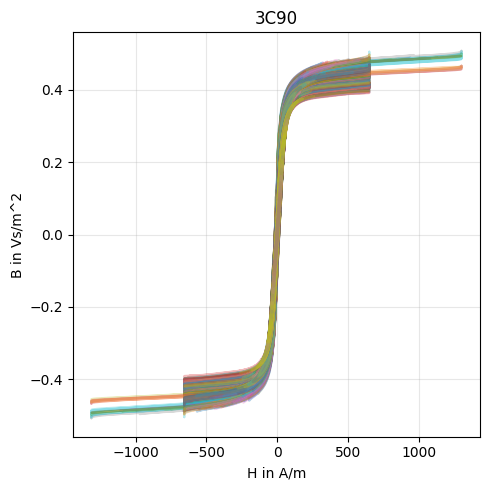

Full sequences overlaid for Material: '3C94'


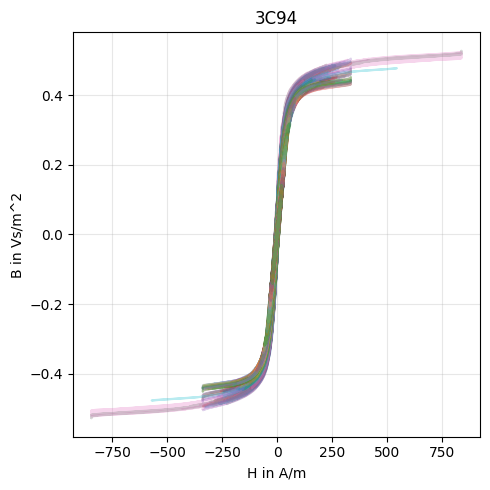

Full sequences overlaid for Material: '3E6'


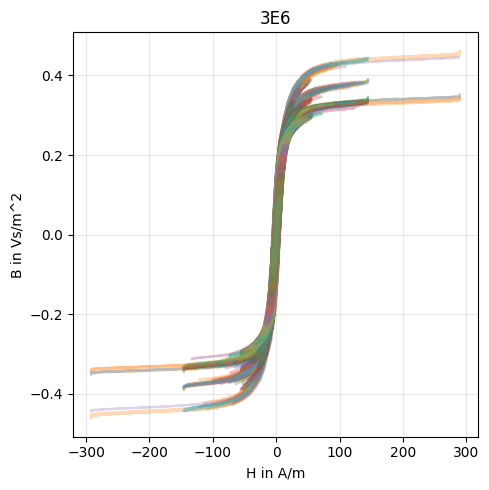

Full sequences overlaid for Material: '3F4'


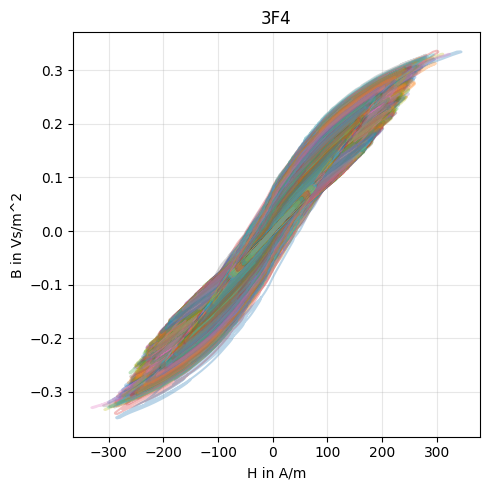

Full sequences overlaid for Material: '77'


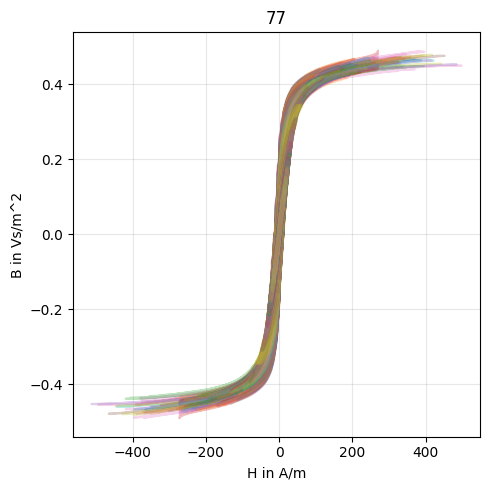

Full sequences overlaid for Material: '78'


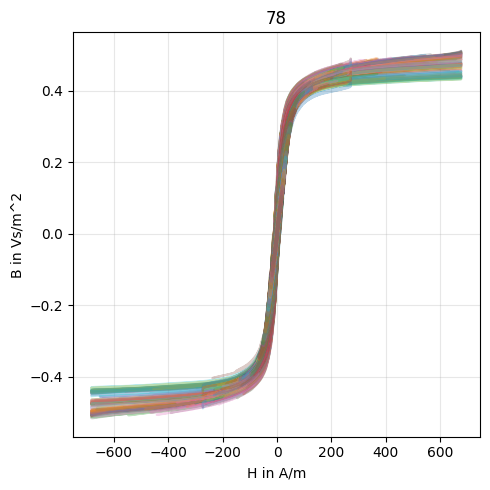

Full sequences overlaid for Material: 'N27'


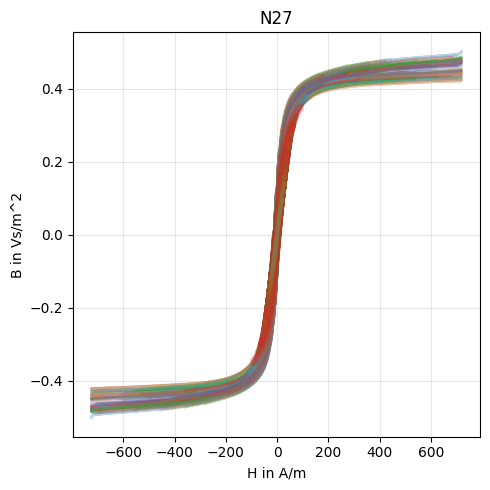

Full sequences overlaid for Material: 'N30'


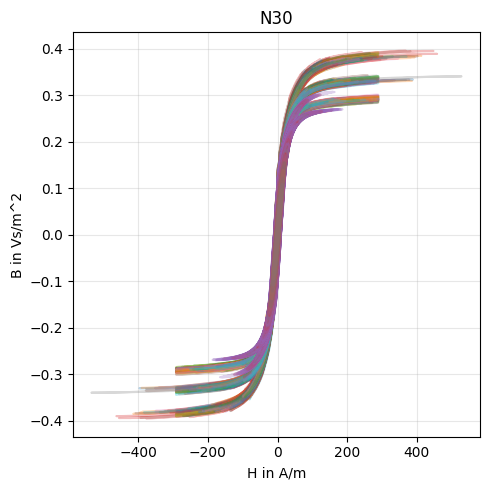

Full sequences overlaid for Material: 'N49'


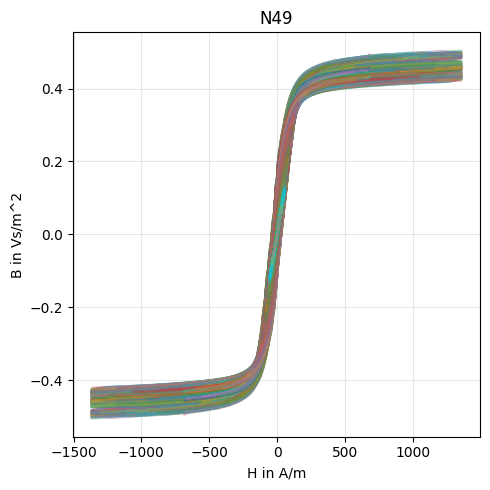

Full sequences overlaid for Material: 'N87'


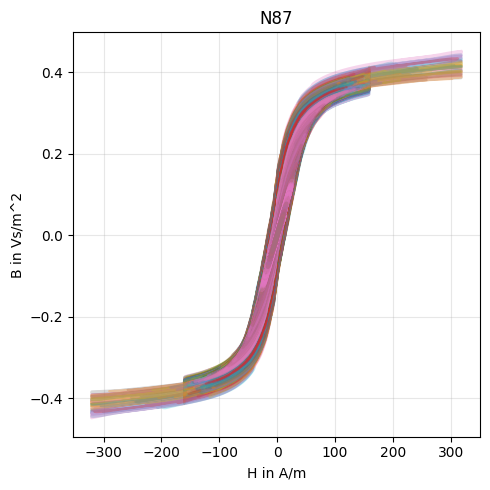

Full sequences overlaid for Material: 'A'


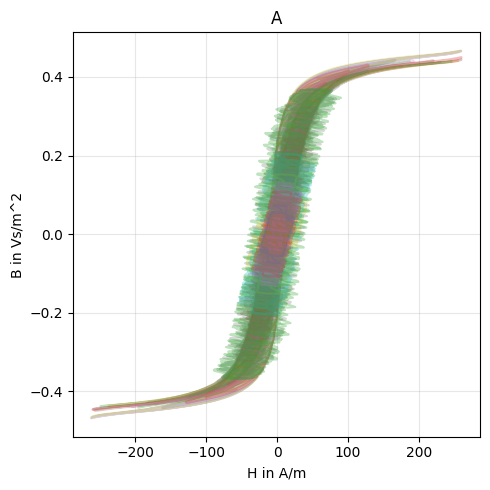

Full sequences overlaid for Material: 'B'


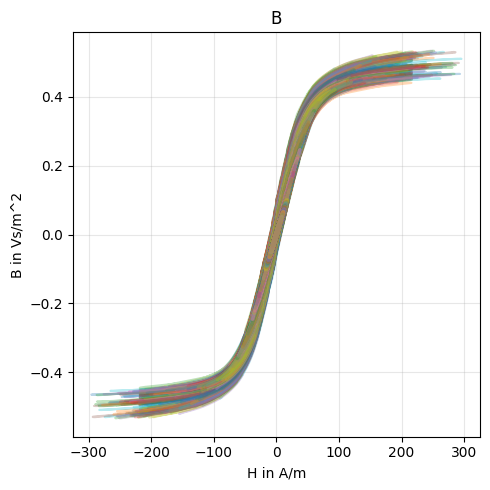

Full sequences overlaid for Material: 'C'


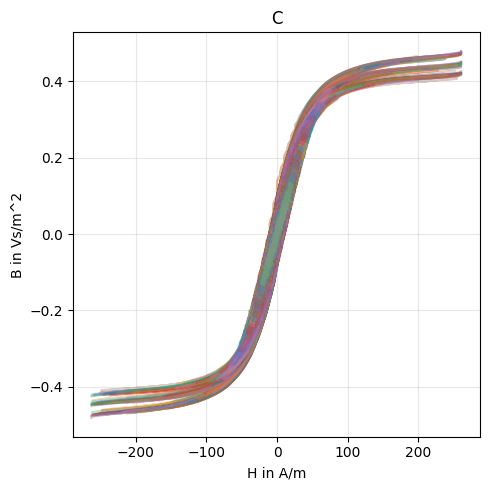

Full sequences overlaid for Material: 'D'


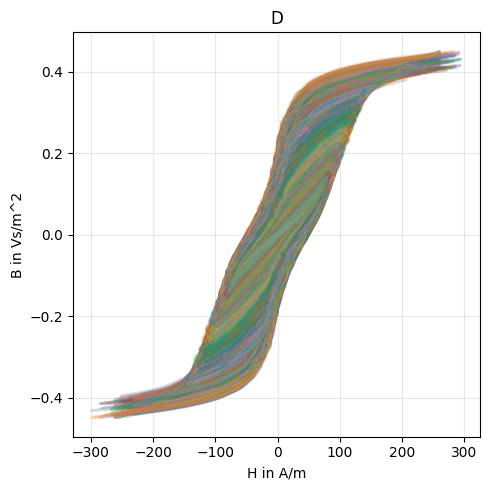

Full sequences overlaid for Material: 'E'


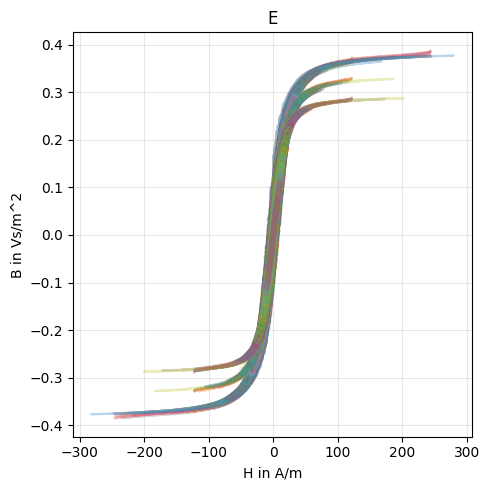

In [10]:
# HB curves
for material_set in data_set:
    print(f"Full sequences overlaid for Material: '{material_set.material_name}'")
    fig, axs = plt.subplots(1,1,figsize=(5, 5))
    for frequency_set in material_set: 
        for sequence_idx in range(frequency_set.B.shape[0]):
            B_values = frequency_set.B[sequence_idx, :]
            H_values = frequency_set.H[sequence_idx, :]
            axs.plot(H_values, B_values, alpha=.3)
    axs.set_title(material_set.material_name)
    axs.set_ylabel("B in Vs/m^2")
    axs.set_xlabel("H in A/m")
    axs.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

Full sequences overlaid for Material: 'A'


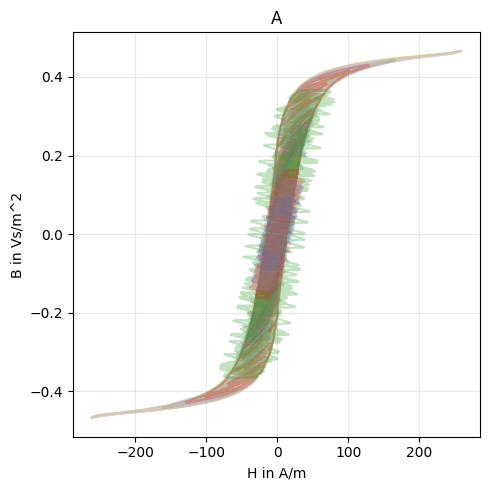

Full sequences overlaid for Material: 'B'


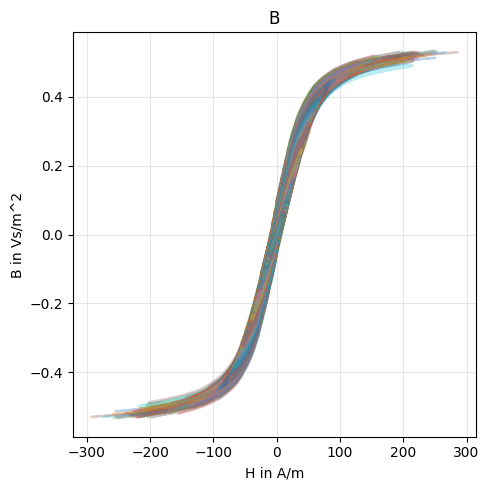

In [11]:
# simply filter the data set if you only want to consider a subset of the full material data:
# e.g. only plot materials 'A' and 'B' at 25 degree celsius
sub_set = data_set.filter_materials(["A", "B"]).filter_temperatures([25])

for material_set in sub_set:
    print(f"Full sequences overlaid for Material: '{material_set.material_name}'")
    fig, axs = plt.subplots(1,1,figsize=(5, 5))
    for frequency_set in material_set: 
        for sequence_idx in range(frequency_set.B.shape[0]):
            B_values = frequency_set.B[sequence_idx, :]
            H_values = frequency_set.H[sequence_idx, :]
            axs.plot(H_values, B_values, alpha=.3)
    axs.set_title(material_set.material_name)
    axs.set_ylabel("B in Vs/m^2")
    axs.set_xlabel("H in A/m")
    axs.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

Exemplary trajectories for Material: '3C90'


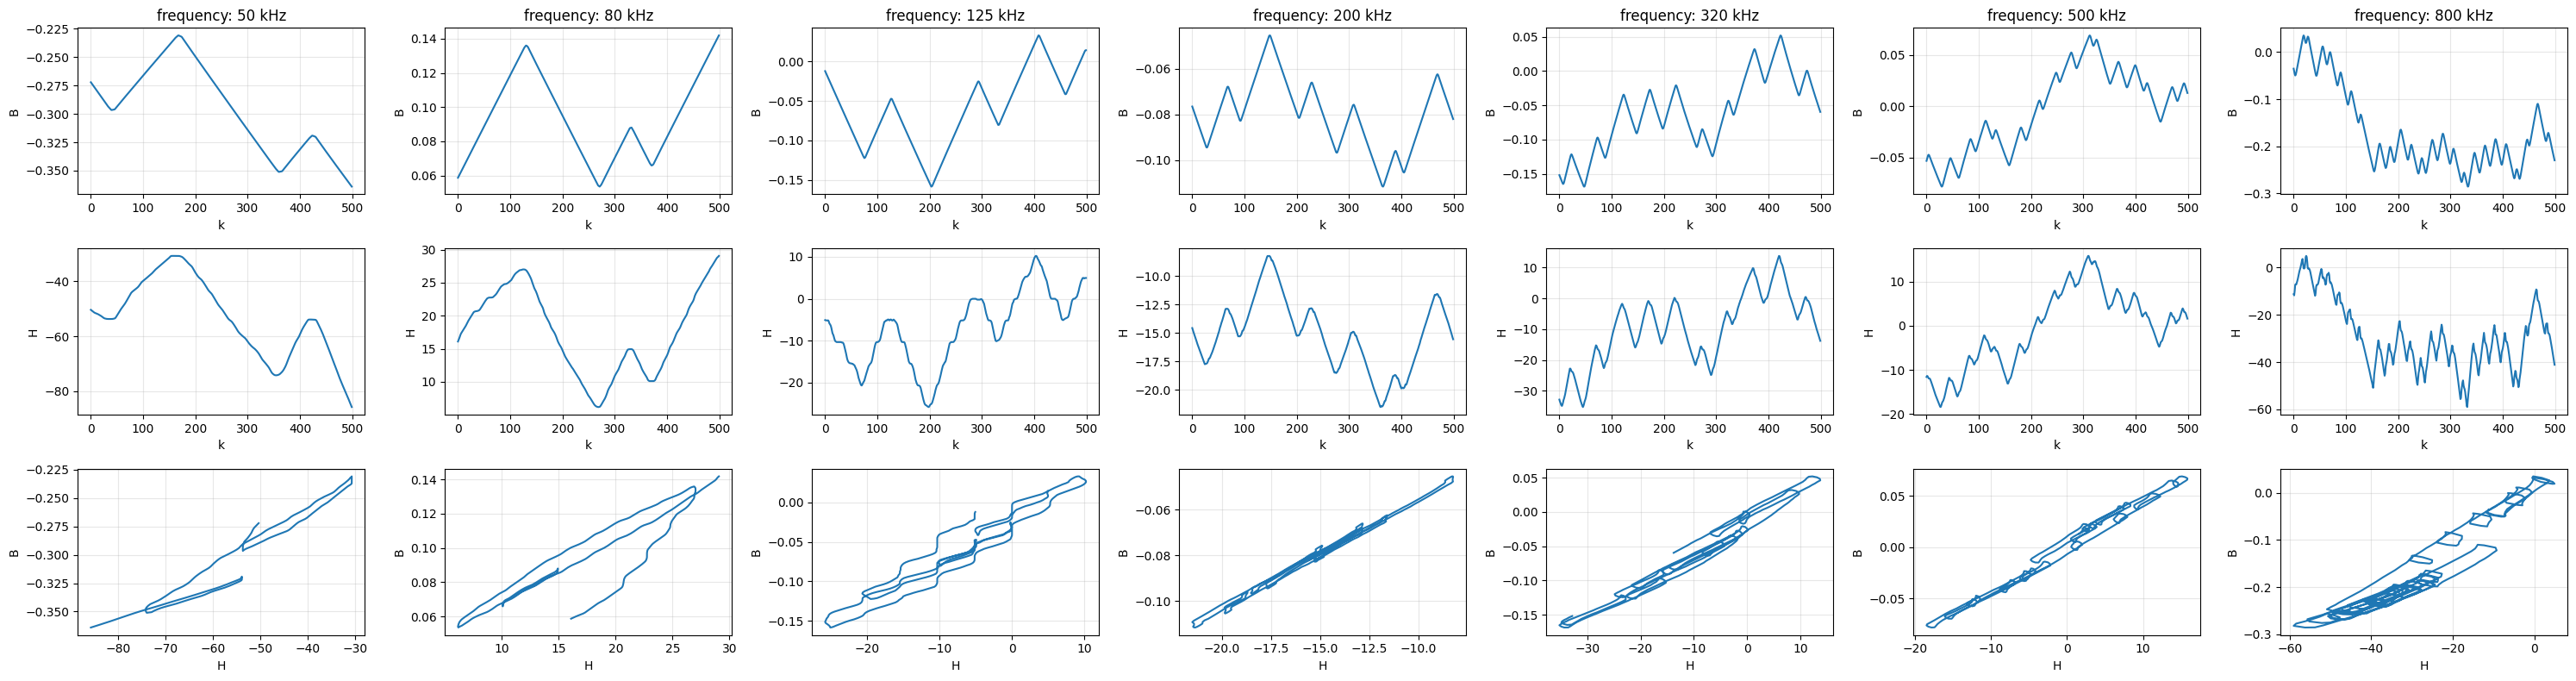

Exemplary trajectories for Material: '3C94'


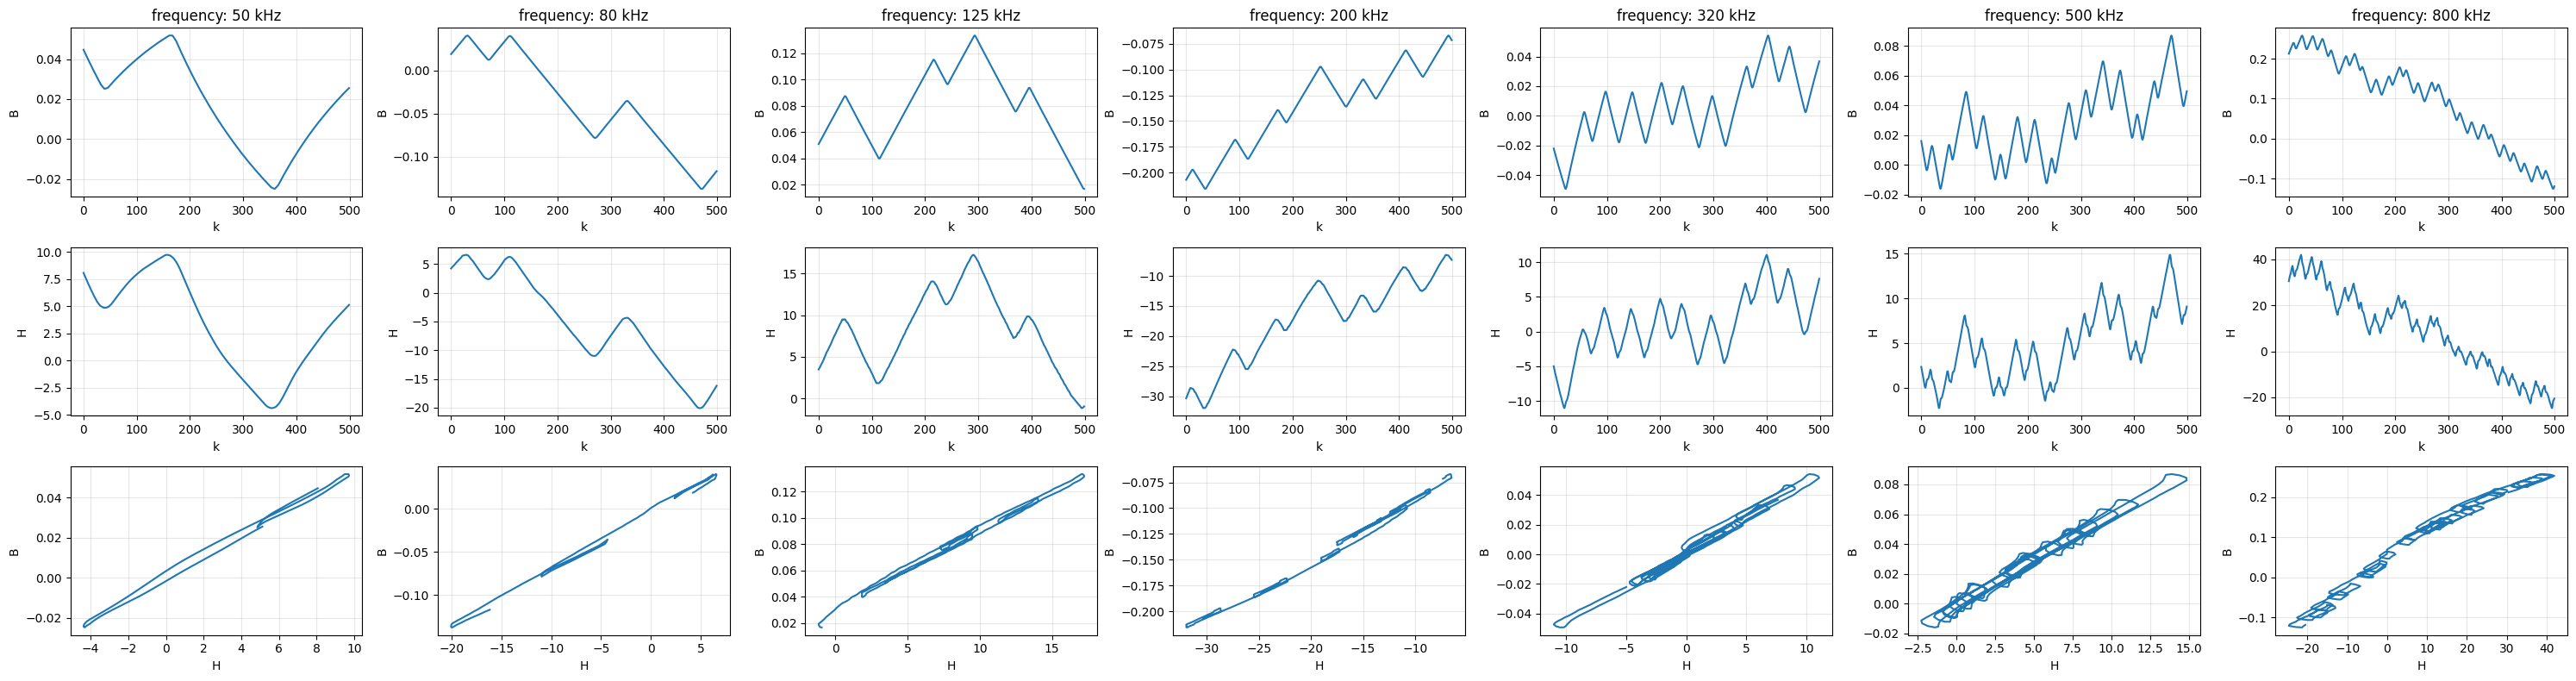

Exemplary trajectories for Material: '3E6'


In [ ]:
for material_set in data_set:
    print(f"Exemplary trajectories for Material: '{material_set.material_name}'")
    plot_frequency_sweep(material_set, loader_key=jax.random.PRNGKey(0), sequence_length=500, batch_size=1)
    plt.show()

## Present models:

In [ ]:
from rhmag.utils.model_evaluation import get_exp_ids

In [ ]:
all_models = get_exp_ids()
all_models

In [ ]:
get_exp_ids(material_name="3C90", model_type="GRU8", exp_name="reduced-features-f32")

In [ ]:
exp_ids = {
    '3C90': '3C90_GRU8_reduced-features-f32_b5ce7dc9_seed12',
    '3C94': '3C90_GRU8_reduced-features-f32_b5ce7dc9_seed12',
    '3E6': '3E6_GRU8_reduced-features-f32_7ff91a7c_seed12',
    '3F4': '3F4_GRU8_reduced-features-f32_a83212e4_seed12',
    '77': '77_GRU8_reduced-features-f32_2eb8cc0c_seed12',
    '78': '78_GRU8_reduced-features-f32_3406a9c8_seed12',
    'N27': 'N27_GRU8_reduced-features-f32_2a482429_seed12',
    'N30': 'N30_GRU8_reduced-features-f32_b3ec1c0f_seed12',
    'N49': 'N49_GRU8_reduced-features-f32_6f23a1f0_seed12',
    'N87': 'N87_GRU8_reduced-features-f32_3f598f03_seed12',
    "A": 'A_GRU8_reduced-features-f32_2a1473b6_seed12',
    "B": 'B_GRU8_reduced-features-f32_c785b2c3_seed12',
    "C": 'C_GRU8_reduced-features-f32_348e220c_seed12',
    "D": 'D_GRU8_reduced-features-f32_b6ac55b5_seed12',
    "E": 'E_GRU8_reduced-features-f32_e88a2583_seed12',
}
models = {material_name: reconstruct_model_from_file(exp_id) for material_name, exp_id in exp_ids.items()}

The models are also `equinox.Module`s. They mostly consist of the actual data-driven model, a normalizer to transfer between the raw material data and data normalized between -1 and 1 (easier to deal with for data-driven models), and a featurization function, which manipulates/extends the input data to the data-driven model with the goal to make the input data more easily interpretable. For instance, the first and second derivative of the magentic flux is particularily helpful in predicting the magnetic field.

In [ ]:
models["A"]

In [ ]:
models["A"].n_params  # not necessarily available for all model types (yet)

In [ ]:
from rhmag.utils.model_evaluation import plot_model_frequency_sweep

In [ ]:
for material_name, model in models.items():
    print(f"Exemplary trajectories including model prediction for Material: '{material_name}' with model '{exp_ids[material_name]}'")
    material_set = data_set.at_material(material_name)
    plot_model_frequency_sweep(model, material_set, loader_key=jax.random.PRNGKey(129), past_size=500)
    plt.show()

In [ ]:
from rhmag.training.jax_routine import val_test
from rhmag.utils.model_evaluation import plot_first_predictions

In [ ]:
print(AVAILABLE_MATERIALS)

In [ ]:
material_name = "D"
model = models[material_name]
material_set = data_set.at_material(material_name)
print(f"Long-term predictions for Material: '{material_name}' with model '{exp_ids[material_name]}'")
test_loss, test_pred_l, test_gt_l = val_test(material_set, model, past_size=100)
for freq_idx, (test_gt, test_pred) in enumerate(zip(test_gt_l, test_pred_l)):
    fig, axs = plot_first_predictions(test_gt, test_pred);
    fig.suptitle(f"Full sequence prediction at frequency: {int(material_set.frequencies[freq_idx] / 1e3)} kHz")
    plt.show()

# for material_name, model in models.items():
#     material_set = data_set.at_material(material_name)
#     print(f"Long-term predictions for Material: '{material_name}' with model '{exp_ids[material_name]}'")
#     test_loss, test_pred_l, test_gt_l = val_test(material_set, model, past_size=100)
#     for freq_idx, (test_gt, test_pred) in enumerate(zip(test_gt_l, test_pred_l)):
#         fig, axs = plot_first_predictions(test_gt, test_pred);
#         fig.suptitle(f"Full sequence prediction at frequency: {int(material_set.frequencies[freq_idx] / 1e3)} kHz")
#         plt.show()